# DMC Example: Particle in 1D Box

We consider as a test case a particle in a 1D box. This is given by the Hamiltonian

$$
    H = -\frac{1}{2}\partial_x^2,
$$

for $x \in [0, 1]$, with homogeneous Dirichet boundary conditions. The exact ground state solution is

$$
    \psi_0(x) = \sin(\pi x),
$$

with energy

$$
    E_0 = \frac{\langle \psi_0 | H | \psi_0 \rangle}{\langle \psi_0 | \psi_0 \rangle} = \frac{\pi^2}{2} \approx 4.9348.
$$

As a trial function, we use

$$
    \psi_T(x) = x(1 - x),
$$

which has a variational energy

$$
    E_V = \frac{\langle \psi_T | H | \psi_T \rangle}{\langle \psi_T | \psi_T \rangle} = 5 > E_0.
$$

In [1]:
import sys
from pydmc import *
%matplotlib inline

In [94]:
nconf = 50
time_step = 1e-2
reference_energy = 5
blocks = 400
steps_per_block = 40
neq = 10
a0 = 1
da = 1e-5
hamiltonian = lambda psi, x: -0.5 * psi.laplacian(x)

Next, we create the guiding wave function:

In [95]:
class GuidingWaveFunction(WaveFunction, GeometryParametrized):

    def __init__(self, box_width):
        self._l = box_width

    def __call__(self, x):
        y = x[0]
        #return (y - self._l/2)*np.sin(np.pi*y/self._l)
        if y > self._l:
            return 0
        return y*(self._l - y)

    def gradient(self, x):
        return gradient_fd(self, x)
    
    def laplacian(self, x):
        return laplacian_fd(self, x)

    def deform(self, da):
        return GuidingWaveFunction(self._l + da)
    
    def geometry_parameters(self):
        return self._l

Now, we generate a set of configurations. In a more advanced algorithm, this should be done by a short VMC run. Here, we just uniformly generate points $x \in [0, 1]$.

In [96]:
np.random.seed(0)
confs = [np.random.rand(1) for _ in range(nconf)]
walkers = [Walker(conf, 1.0) for conf in confs]

And finally, initialize the DMC runner and perform diffusion Monte Carlo.

In [91]:
brancher = SRBrancher()
#brancher = SplitJoinBrancher()

ar = DiffuseAcceptRejectDMC(fixed_node=True)
guiding_wf = GuidingWaveFunction(a0)

np.random.seed(0)
confs = [np.random.uniform(low=0, high=1, size=1) for _ in range(nconf)]
walkers = [Walker(conf, 1.0) for conf in confs]

dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy)

dmc.run_dmc(time_step, blocks, steps_per_block, neq=neq, progress=True)

100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


The DMC energy estimate is updated and saved during the run. The last value of the estimate is the most accurate energy that was obtained. Additionally, an estimate on the error is computed; this is usually underestimated, so take care.

In [92]:
energy = dmc.energy_estimate[-1]
err = dmc.energy_error[-1]
print(f"Energy: {energy:.5f} +/- {err:.5f}")
print(f"Exact:  {np.pi**2/2:.5f}")

Energy: 4.95488 +/- 0.02248
Exact:  4.93480


Let's examine how the energy esimate behaves during the run:

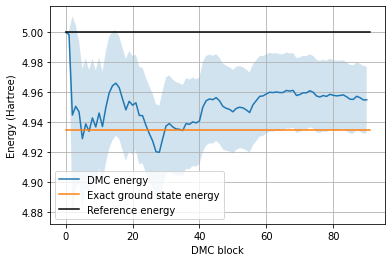

In [93]:
plt.figure()
ns = np.arange(0, len(dmc.energy_estimate))
plt.plot(ns, dmc.energy_estimate, label="DMC energy")
plt.fill_between(ns, 
    dmc.energy_estimate - dmc.energy_error, 
    dmc.energy_estimate + dmc.energy_error, alpha=0.2)

exact = np.pi**2/2                    
plt.plot([0, len(dmc.energy_estimate)], [exact, exact], label="Exact ground state energy")
plt.plot([0, len(dmc.energy_estimate)], [reference_energy, reference_energy], "black", label="Reference energy")
plt.legend()
plt.xlabel("DMC block")
plt.ylabel("Energy (Hartree)")
plt.grid()